In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI
import scarches as sca
import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Get AnnData

In [4]:
adata = scv.datasets.pancreas()

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 21611 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


Get annotations

In [7]:
import gdown
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

KeyboardInterrupt: 

In [7]:
data_path='data/Pancreas/'
sca.utils.add_annotations(adata, [data_path+'PanglaoDB_markers_27_Mar_2020.gmt',data_path+'reactome.gmt'], min_genes=5, clean=True)


In [8]:
#Remove all genes not present in annotations
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [9]:
#Filter out terms with less than 12 genes 
select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

Instantiate model and train

In [10]:
omega_reactome=torch.ones(adata.varm["I"][:,50:].shape[1])
omega_panglao=torch.zeros(adata.varm["I"][:,:50].shape[1])
omega=torch.cat((omega_panglao,omega_reactome))

In [11]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)

mask: tensor([[0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0.

In [14]:
vae.train(omega=omega)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]Init the group lasso proximal operator for the main terms.
INFO     velovi:                                                                                                   
         Number of deactivated terms: 0                                                                            
INFO     velovi: any_change: False                                                                                 
INFO     velovi:                                                                                                   
         Number of deactivated terms: 0                                                                            
INFO     velovi: any_change: False                                                                                 
Epoch 2/500:   0%|          | 1/500 [00:21<2:57:35, 21.35s/it, loss=-345, v_num=1, no. deactivated terms=0, validation_loss=-312]INFO     velovi:                                                

In [30]:
#Load model
vae=VELOVI.load('trained_models/velo_interpret_single_panglao_reactome', adata)

INFO     File trained_models/velo_interpret_single_panglao_reactome/model.pt already downloaded                    
mask: tensor([[0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 1., 1., 0., 0., 0., 0.],
 

Get latent representation

In [31]:
adata.obsm["latent"]=vae.get_latent()

In [32]:
sc.pp.neighbors(adata, use_rep='latent')

In [33]:
sc.tl.umap(adata)

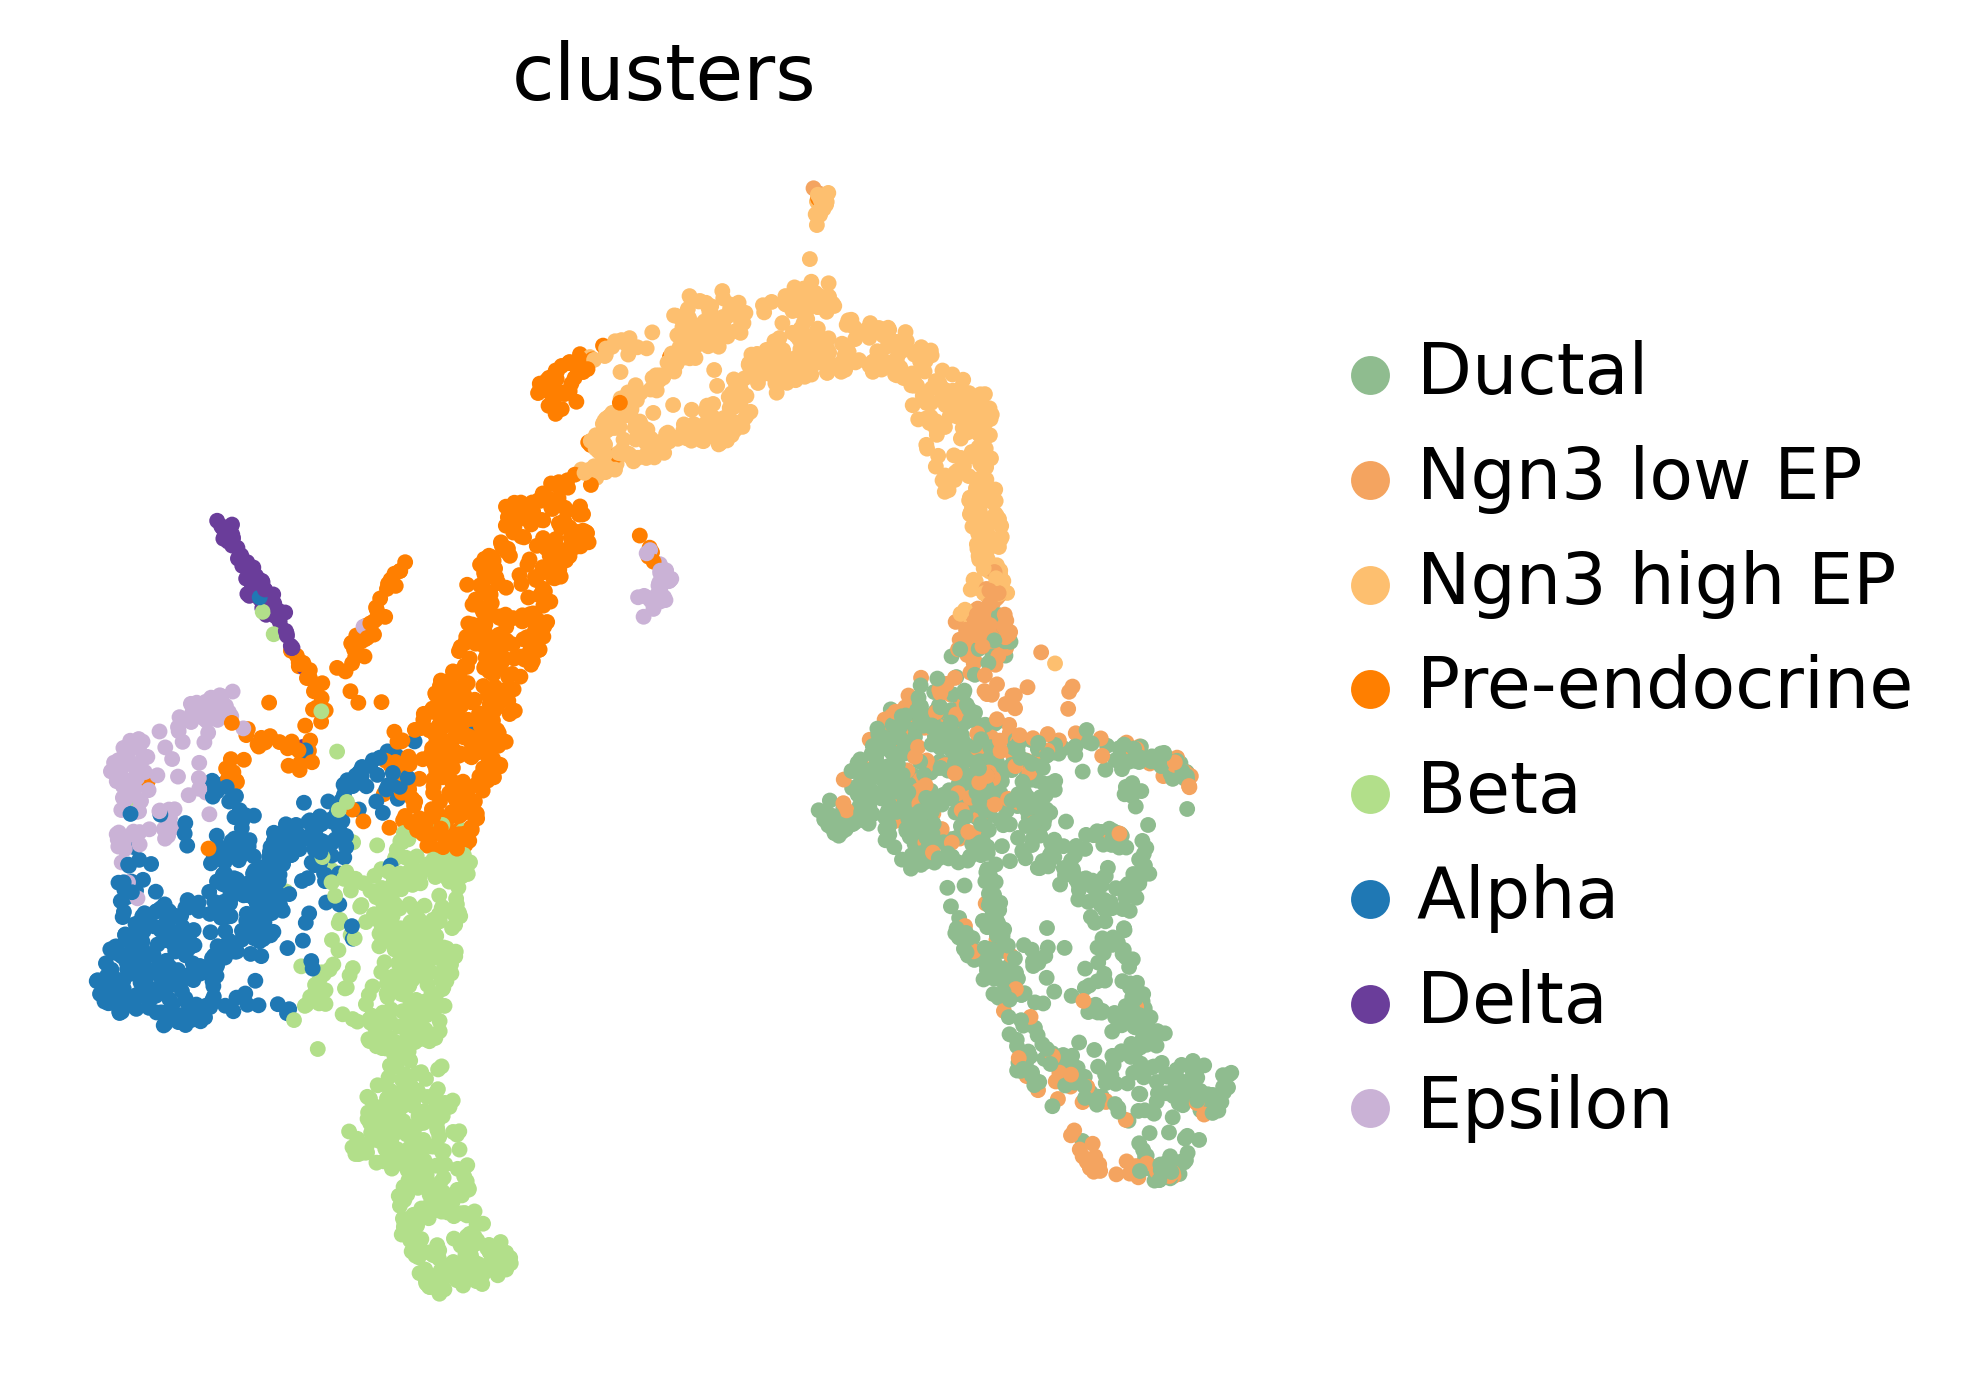

In [34]:
sc.pl.umap(adata, color='clusters', frameon=False)

Latent enrichment

In [35]:
scores_ct = vae.latent_enrich('clusters', adata=adata, exact=True)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                         

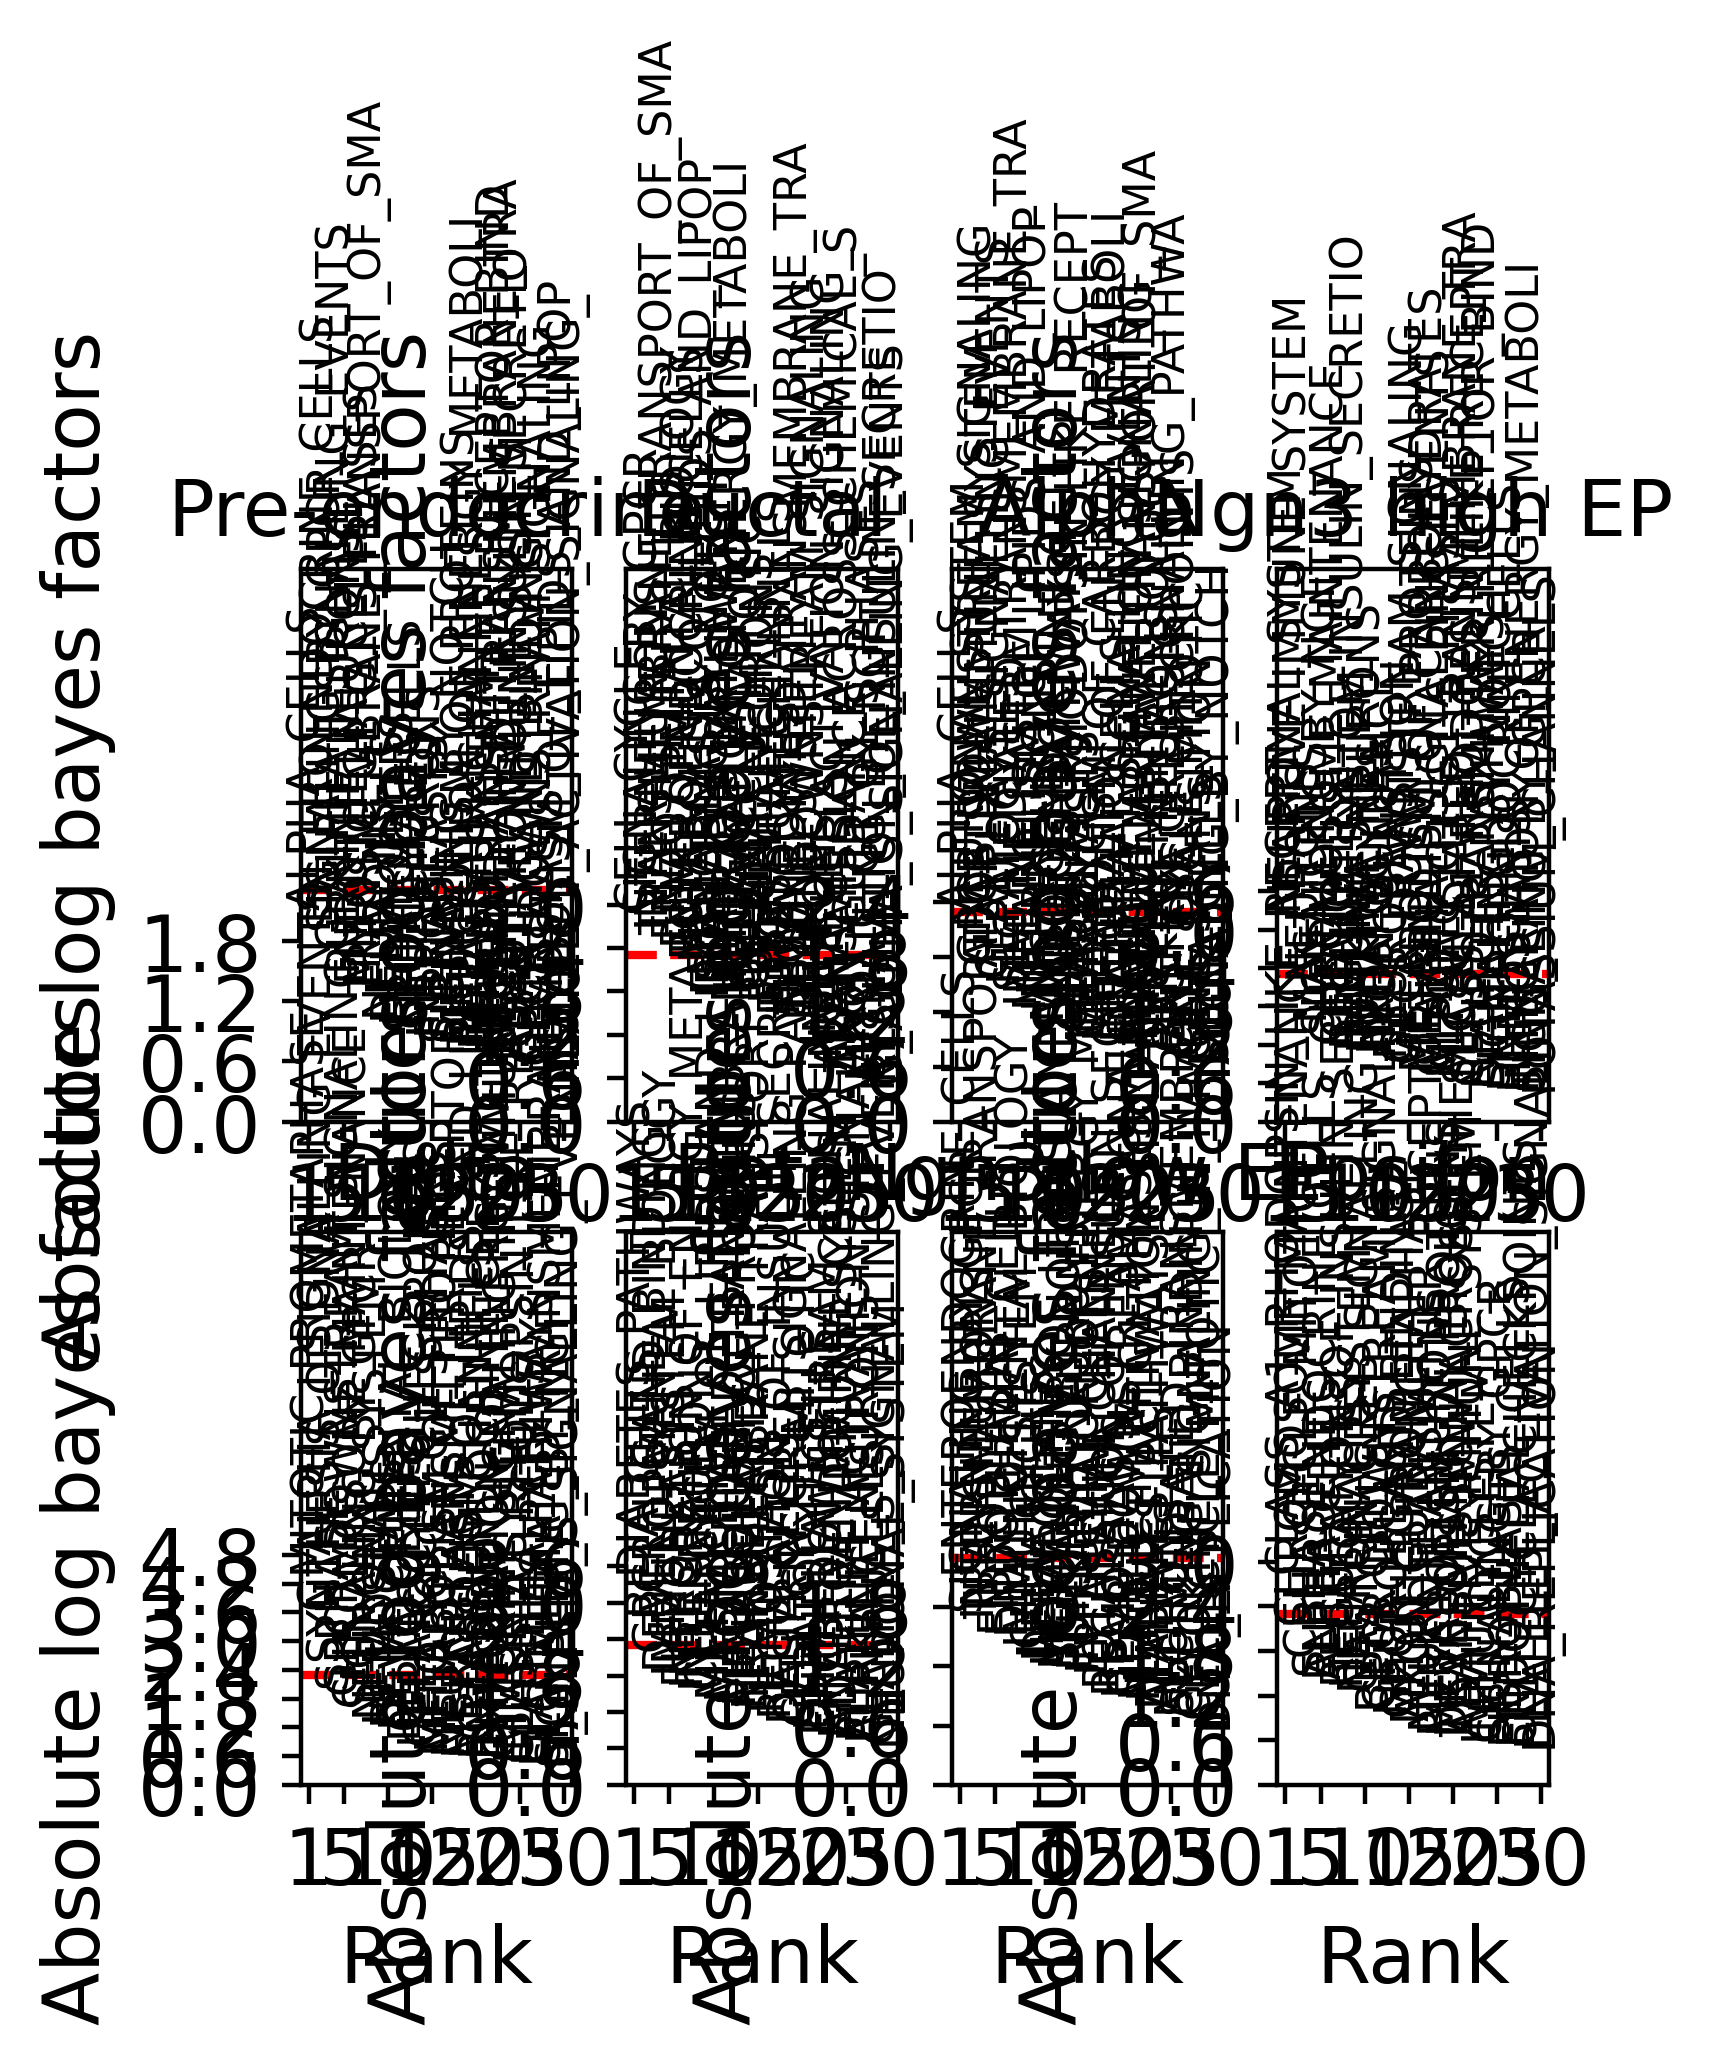

In [36]:
fig = sca.plotting.plot_abs_bfs(adata, n_cols=4, scale_y=2.6, yt_step=0.6)

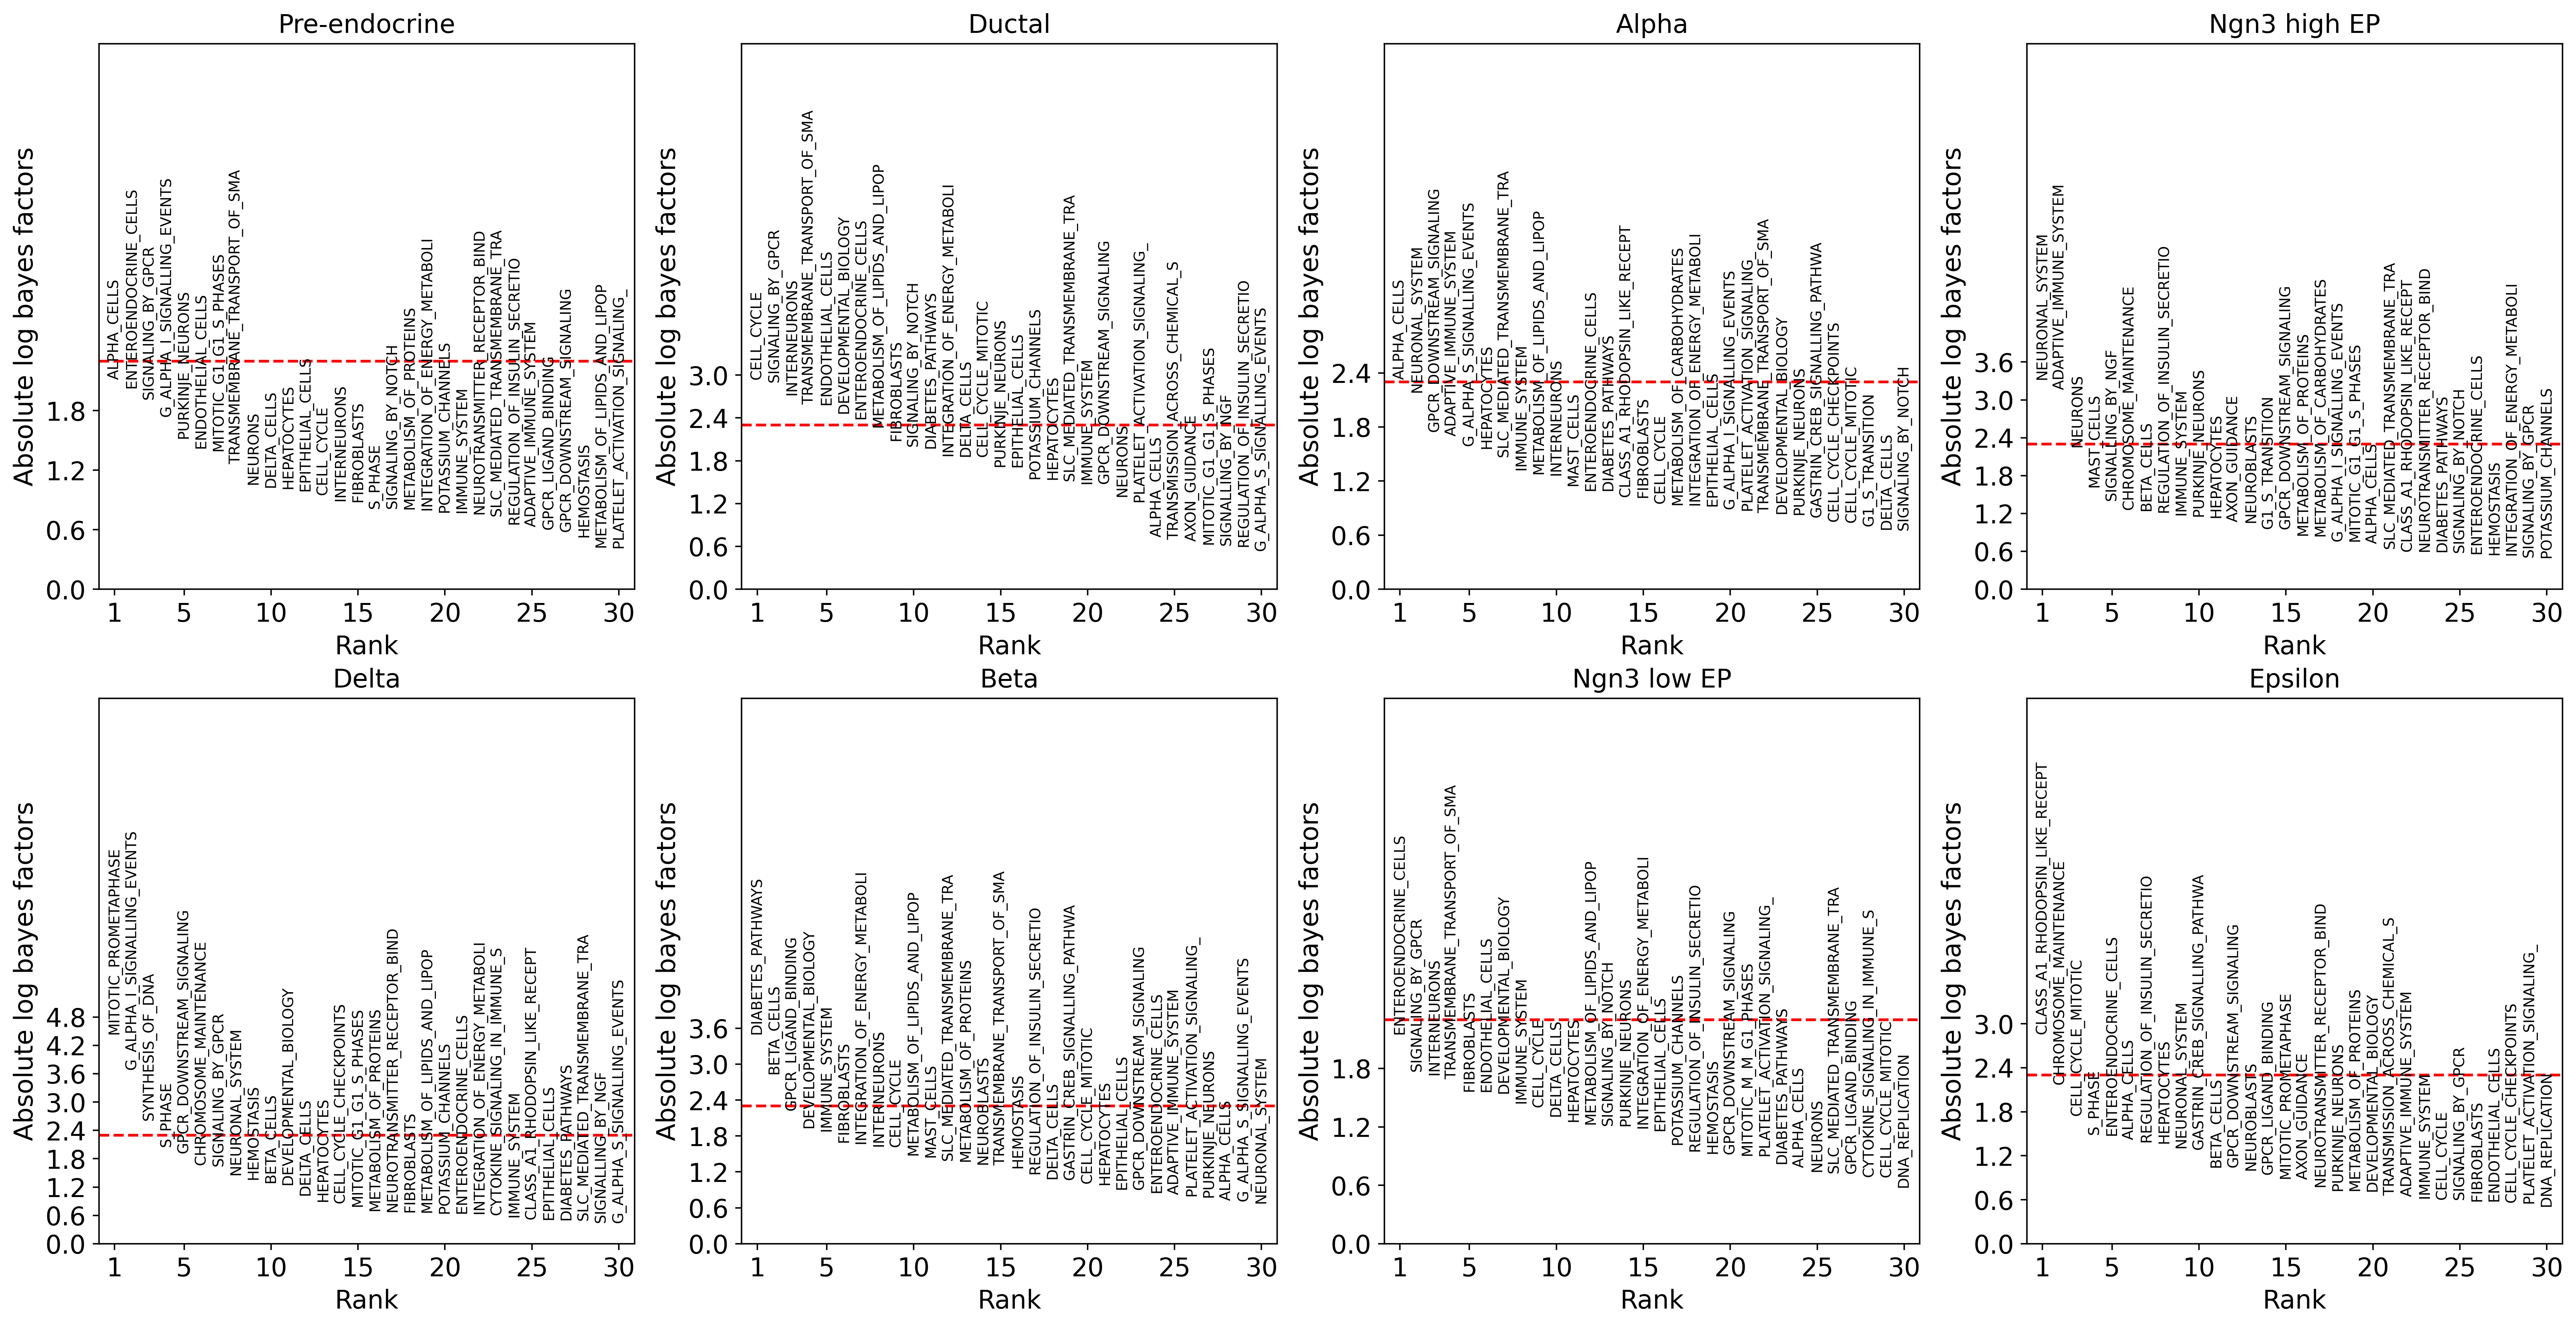

In [37]:
fig.set_size_inches(24, 12)
fig

Plot latent space to visualize gene programs

In [38]:
#get latent directions
vae.latent_directions()

In [39]:
terms = adata.uns['terms']
terms

['ALPHA_CELLS',
 'BETA_CELLS',
 'DELTA_CELLS',
 'ENDOTHELIAL_CELLS',
 'ENTEROENDOCRINE_CELLS',
 'EPITHELIAL_CELLS',
 'FIBROBLASTS',
 'HEPATOCYTES',
 'INTERNEURONS',
 'MAST_CELLS',
 'NEUROBLASTS',
 'NEURONS',
 'PURKINJE_NEURONS',
 'SIGNALLING_BY_NGF',
 'DEVELOPMENTAL_BIOLOGY',
 'CELL_CYCLE',
 'GASTRIN_CREB_SIGNALLING_PATHWA',
 'TRANSMISSION_ACROSS_CHEMICAL_S',
 'NEURONAL_SYSTEM',
 'SIGNALING_BY_GPCR',
 'CLASS_A1_RHODOPSIN_LIKE_RECEPT',
 'INTEGRATION_OF_ENERGY_METABOLI',
 'CELL_CYCLE_MITOTIC',
 'NEUROTRANSMITTER_RECEPTOR_BIND',
 'CELL_CYCLE_CHECKPOINTS',
 'DIABETES_PATHWAYS',
 'TRANSMEMBRANE_TRANSPORT_OF_SMA',
 'METABOLISM_OF_PROTEINS',
 'G1_S_TRANSITION',
 'AXON_GUIDANCE',
 'REGULATION_OF_INSULIN_SECRETIO',
 'SLC_MEDIATED_TRANSMEMBRANE_TRA',
 'GPCR_DOWNSTREAM_SIGNALING',
 'G_ALPHA_I_SIGNALLING_EVENTS',
 'G_ALPHA_S_SIGNALLING_EVENTS',
 'SYNTHESIS_OF_DNA',
 'MITOTIC_G1_G1_S_PHASES',
 'MITOTIC_M_M_G1_PHASES',
 'GPCR_LIGAND_BINDING',
 'CHROMOSOME_MAINTENANCE',
 'METABOLISM_OF_LIPIDS_AND_LIP

In [56]:
select_terms = ['ALPHA_CELLS', 'ENTEROENDOCRINE_CELLS',]
idx = [terms.index(term) for term in select_terms]

In [57]:
latents = (adata.obsm["latent"]*adata.uns['directions'])[:, idx]

In [54]:
adata.obs

clusters_coarse       clusters   S_score  G2M_score  \
index                                                                  
AAACCTGAGAGGGATA   Pre-endocrine  Pre-endocrine -0.224902  -0.252071   
AAACCTGAGCCTTGAT          Ductal         Ductal -0.014707  -0.232610   
AAACCTGAGGCAATTA       Endocrine          Alpha -0.171255  -0.286834   
AAACCTGCATCATCCC          Ductal         Ductal  0.599244   0.191243   
AAACCTGGTAAGTGGC    Ngn3 high EP   Ngn3 high EP -0.179981  -0.126030   
...                          ...            ...       ...        ...   
TTTGTCAAGTGACATA   Pre-endocrine  Pre-endocrine -0.235896  -0.266101   
TTTGTCAAGTGTGGCA    Ngn3 high EP   Ngn3 high EP  0.279374  -0.204047   
TTTGTCAGTTGTTTGG          Ductal         Ductal -0.045692  -0.208907   
TTTGTCATCGAATGCT       Endocrine          Alpha -0.240576  -0.206865   
TTTGTCATCTGTTTGT       Endocrine        Epsilon -0.136407  -0.184763   

                  initial_size_unspliced  initial_size_spliced  initial_size  \
index                                                                          
AAACCTGAGAGGGATA                  1575.0                4954.0        4954.0   
AAACCTGAGCCTTGAT                   978.0                7071.0        7071.0   
AAACCTGAGGCAATTA                  1095.0                4070.0        4070.0   
AAACCTGCATCATCCC                  1655.0                8362.0        8362.0   
AAACCTGGTAAGTGGC                  1014.0                5026.0        5026.0   
...                                  ...                   ...           ...   
TTTGTCAAGTGACATA                  2488.0                9219.0        9219.0   
TTTGTCAAGTGTGGCA                   943.0                7298.0        7298.0   
TTTGTCAGTTGTTTGG                   789.0                5234.0        5234.0   
TTTGTCATCGAATGCT                  1851.0               10260.0       10260.0   
TTTGTCATCTGTTTGT                  1439.0                5922.0        5922.0   

                     n_counts  ALPHA_CELLS  ENTEROENDOCRINE_CELLS  \
index                                                               
AAACCTGAGAGGGATA  5232.517090    -1.536562               0.773779   
AAACCTGAGCCTTGAT  5332.042969    -0.622372              -2.631000   
AAACCTGAGGCAATTA  5293.054199     0.234975               0.598944   
AAACCTGCATCATCCC  5348.825195    -1.044729              -0.575200   
AAACCTGGTAAGTGGC  5309.142578    -0.276947               0.166796   
...                       ...          ...                    ...   
TTTGTCAAGTGACATA  5288.986328    -2.771077               0.888716   
TTTGTCAAGTGTGGCA  5392.802734    -1.052465              -0.952128   
TTTGTCAGTTGTTTGG  5410.578613    -0.110712              -1.313582   
TTTGTCATCGAATGCT  5400.129883     1.380708               0.284814   
TTTGTCATCTGTTTGT  5338.429199     0.949769               0.591357   

                  velocity_self_transition  velocity_length  \
index                                                         
AAACCTGAGAGGGATA                  0.119073             0.36   
AAACCTGAGCCTTGAT                  0.208391             0.30   
AAACCTGAGGCAATTA                  0.091829             0.34   
AAACCTGCATCATCCC                  0.160326             0.32   
AAACCTGGTAAGTGGC                  0.112075             0.34   
...                                    ...              ...   
TTTGTCAAGTGACATA                  0.007263             0.37   
TTTGTCAAGTGTGGCA                  0.038142             0.34   
TTTGTCAGTTGTTTGG                  0.170101             0.28   
TTTGTCATCGAATGCT                  0.169565             0.35   
TTTGTCATCTGTTTGT                  0.132993             0.33   

                  velocity_confidence  velocity_confidence_transition  
index                                                                  
AAACCTGAGAGGGATA             0.896680                        0.221785  
AAACCTGAGCCTTGAT             0.897434                        0.127126  
AAACCTGAGGCAATTA             0.87

In [58]:
adata.obs['ALPHA_CELLS'] = latents[:, 0]
adata.obs['ENTEROENDOCRINE_CELLS'] = latents[:, 1]

sc.pl.scatter(adata, x='ALPHA_CELLS', y='ENTEROENDOCRINE_CELLS', color='Alpha', size=10)#, save="2.png")

ValueError: `x`, `y`, and potential `color` inputs must all come from either `.obs` or `.var`

Save trained model

In [15]:
vae.save('velo_interpret_single_panglao_reactome2')

### Analysis of saved model

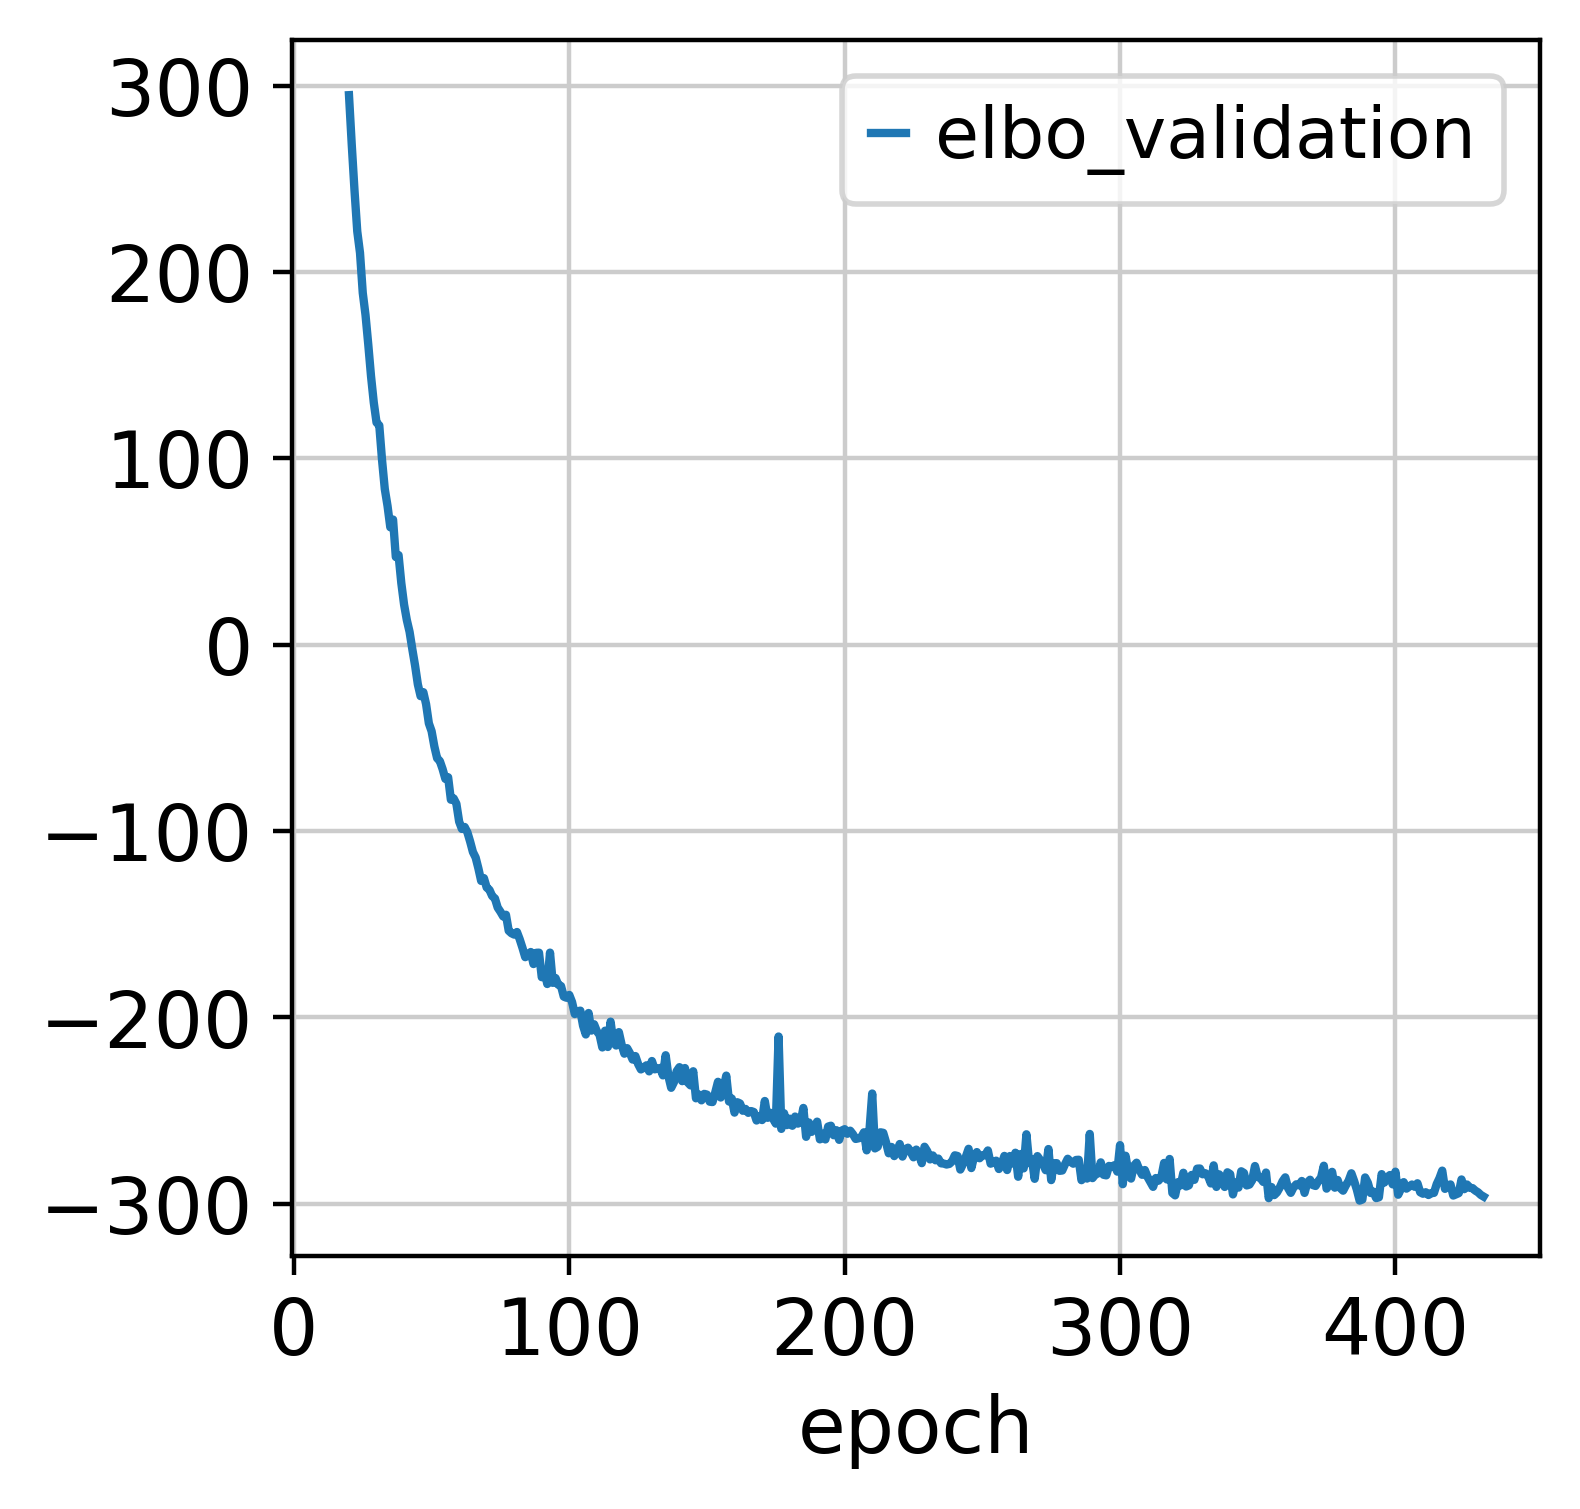

In [14]:
fig, ax = plt.subplots()
#vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

Comparison velo_interpret to velo_orig

In [50]:
#Compare the MSE for unspliced and spliced counts between Velo_interpret and original 

import pandas as pd
pred=vae.get_expression_fit()
pred_s=pred[0]
pred_u=pred[1]
GT_s=adata.layers["Ms"]
GT_u=adata.layers["Mu"]
MSE_s=np.mean((pred_s-GT_s)**2, axis=0)
MSE_u=np.mean((pred_u-GT_u)**2, axis=0)

velo_interpret_MSE=pd.DataFrame([MSE_s,MSE_u]).T

#Read in saved MSE from velovi_orig
velo_orig_MSE=pd.read_csv("MSE_velovi_orig.csv", index_col="index")

#Calculate log10 MSE ratios
log10MSE_s=np.log10(velo_orig_MSE["0"]/velo_interpret_MSE[0])
log10MSE_u=np.log10(velo_orig_MSE["1"]/velo_interpret_MSE[1])
log10MSE_s=log10MSE_s.dropna()
log10MSE_u=log10MSE_u.dropna()

#Combine MSE for spliced and unspliced into 1 dataframe
MSE_combined=pd.DataFrame([log10MSE_s,log10MSE_u]).T
MSE_combined=MSE_combined.rename(columns={0:"spliced",1:"unspliced"})

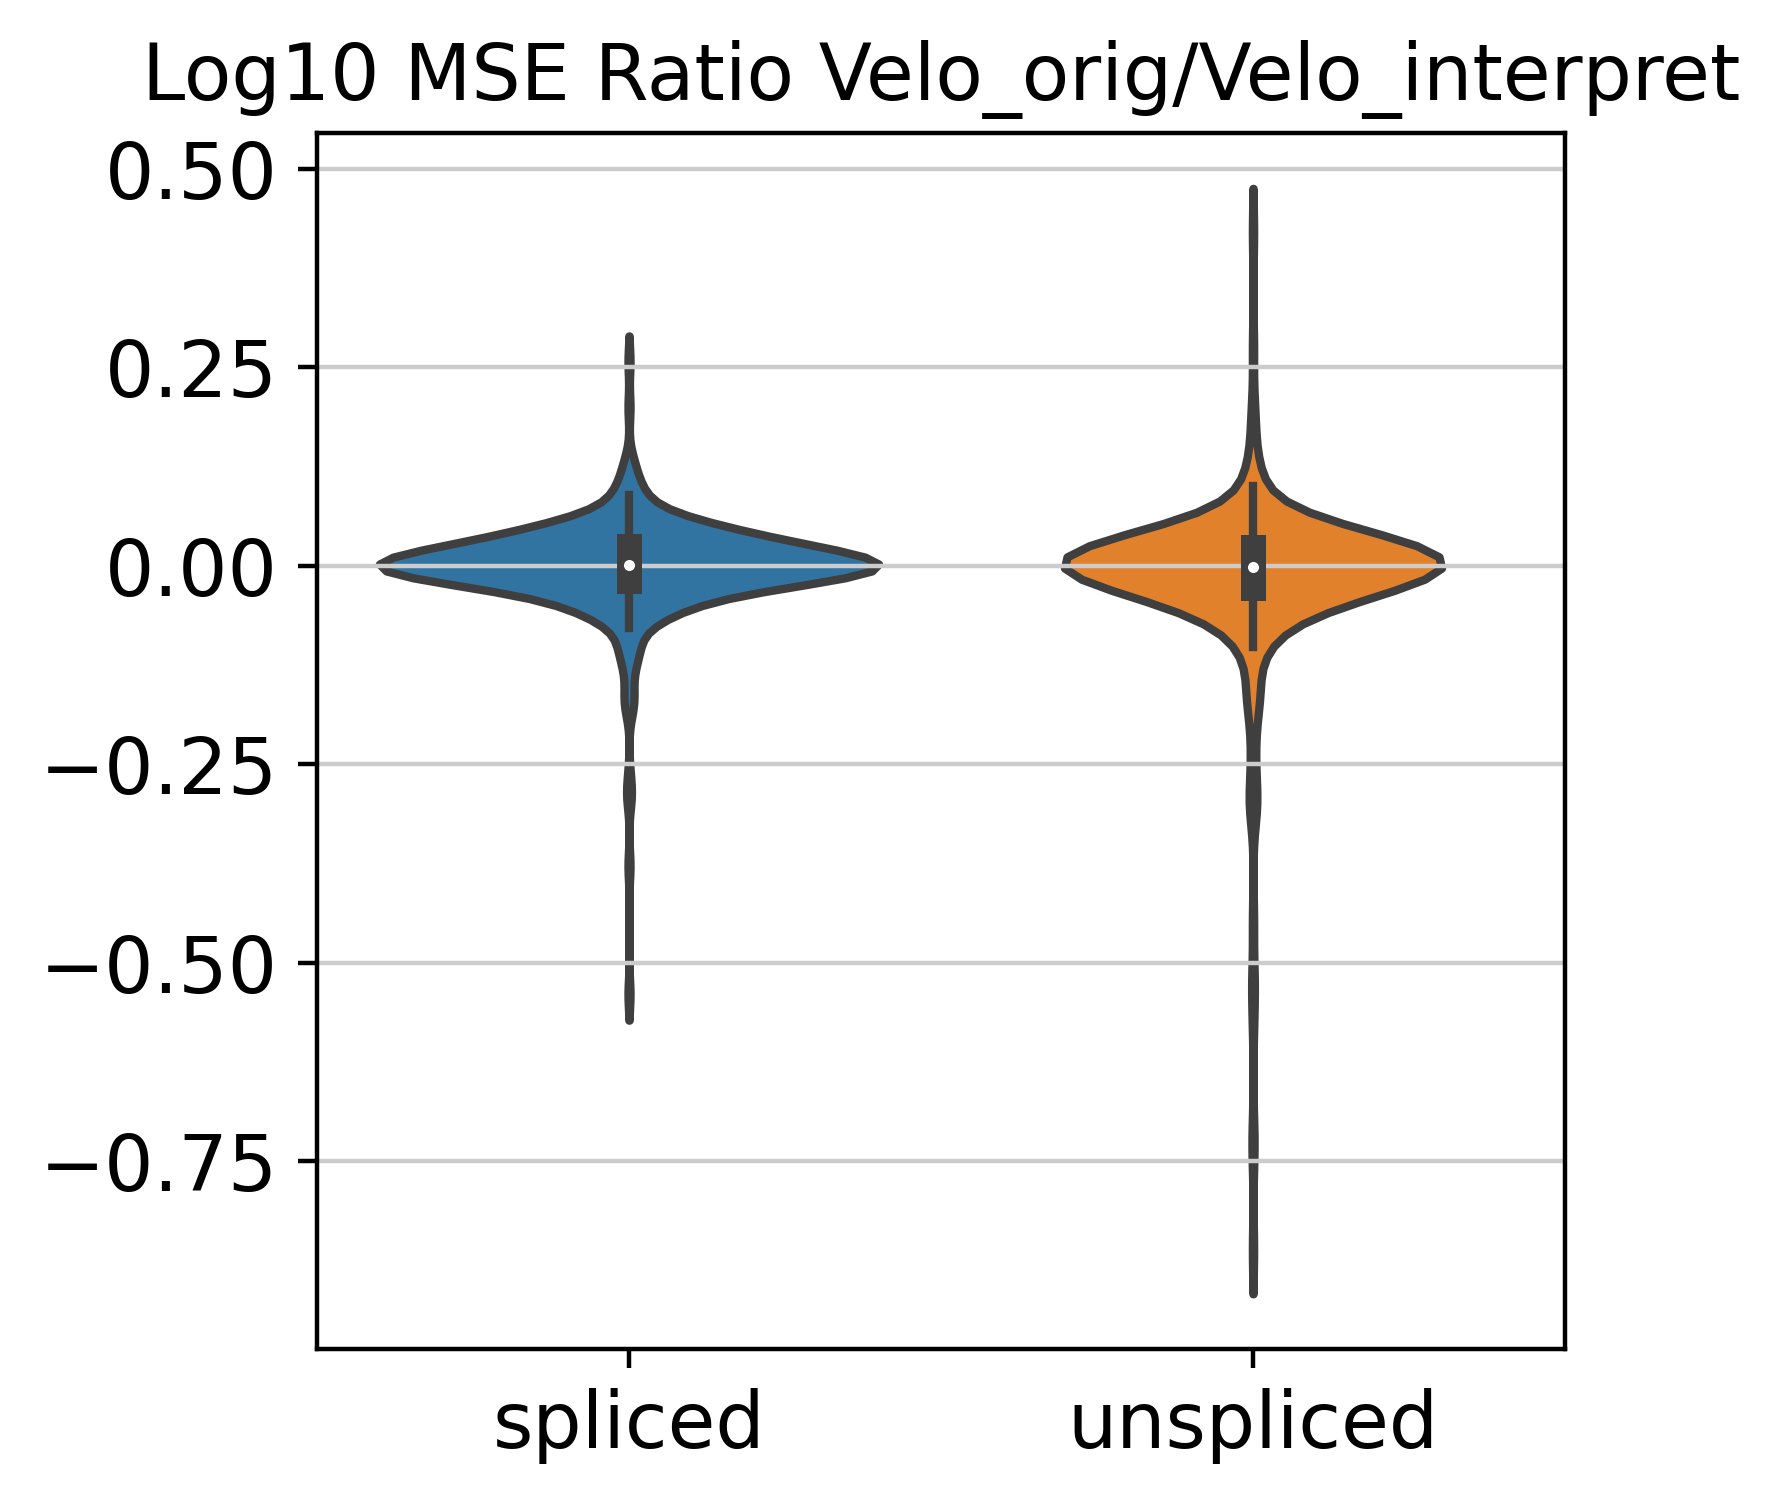

In [51]:
#Get violin plot of log10 MSEs
ax=sns.violinplot(data=MSE_combined)
ax.set_title("Log10 MSE Ratio Velo_orig/Velo_interpret")
MSE_fig=ax.get_figure()
#MSE_fig.savefig("figures/decoder2/log10MSE.png") 

In [44]:
#get velocity confidence for Velo interpret double
scv.tl.velocity_graph(adata)
scv.tl.velocity_confidence(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:18) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [46]:
velo_orig_vc=pd.read_csv("vel_conf_veloVI.csv", index_col="index")
velo_orig_vc=velo_orig_vc.rename(columns={"velocity_confidence":"vc_veloVI"})
scvelo_vc=pd.read_csv("vel_conf_scVelo.csv", index_col="index")
scvelo_vc=scvelo_vc.rename(columns={"velocity_confidence":"vc_scvelo"})
# velo_int_s_vc=pd.read_csv("vel_conf_Velo_Int_S.csv", index_col="index")
# velo_int_s_vc=velo_int_s_vc.rename(columns={"velocity_confidence":"vc_velo_interpret_single"})
velo_int_d_vc=pd.DataFrame(adata.obs["velocity_confidence"])
velo_int_d_vc=velo_int_d_vc.rename(columns={"velocity_confidence":"vc_velo_interpret_single"})

In [47]:
vc_combined=pd.concat([scvelo_vc,velo_orig_vc,velo_int_d_vc],axis=1)

In [48]:
vc_combined

vc_scvelo  vc_veloVI  vc_velo_interpret_single
index                                                           
AAACCTGAGAGGGATA   0.769216   0.900101                  0.896680
AAACCTGAGCCTTGAT   0.792310   0.910085                  0.897434
AAACCTGAGGCAATTA   0.733762   0.840806                  0.873588
AAACCTGCATCATCCC   0.746999   0.881598                  0.905368
AAACCTGGTAAGTGGC   0.775375   0.905970                  0.911187
...                     ...        ...                       ...
TTTGTCAAGTGACATA   0.589383   0.853201                  0.861832
TTTGTCAAGTGTGGCA   0.717359   0.838502                  0.834472
TTTGTCAGTTGTTTGG   0.657952   0.858520                  0.820456
TTTGTCATCGAATGCT   0.809008   0.901181                  0.900746
TTTGTCATCTGTTTGT   0.704007   0.833331                  0.858083

[3696 rows x 3 columns]

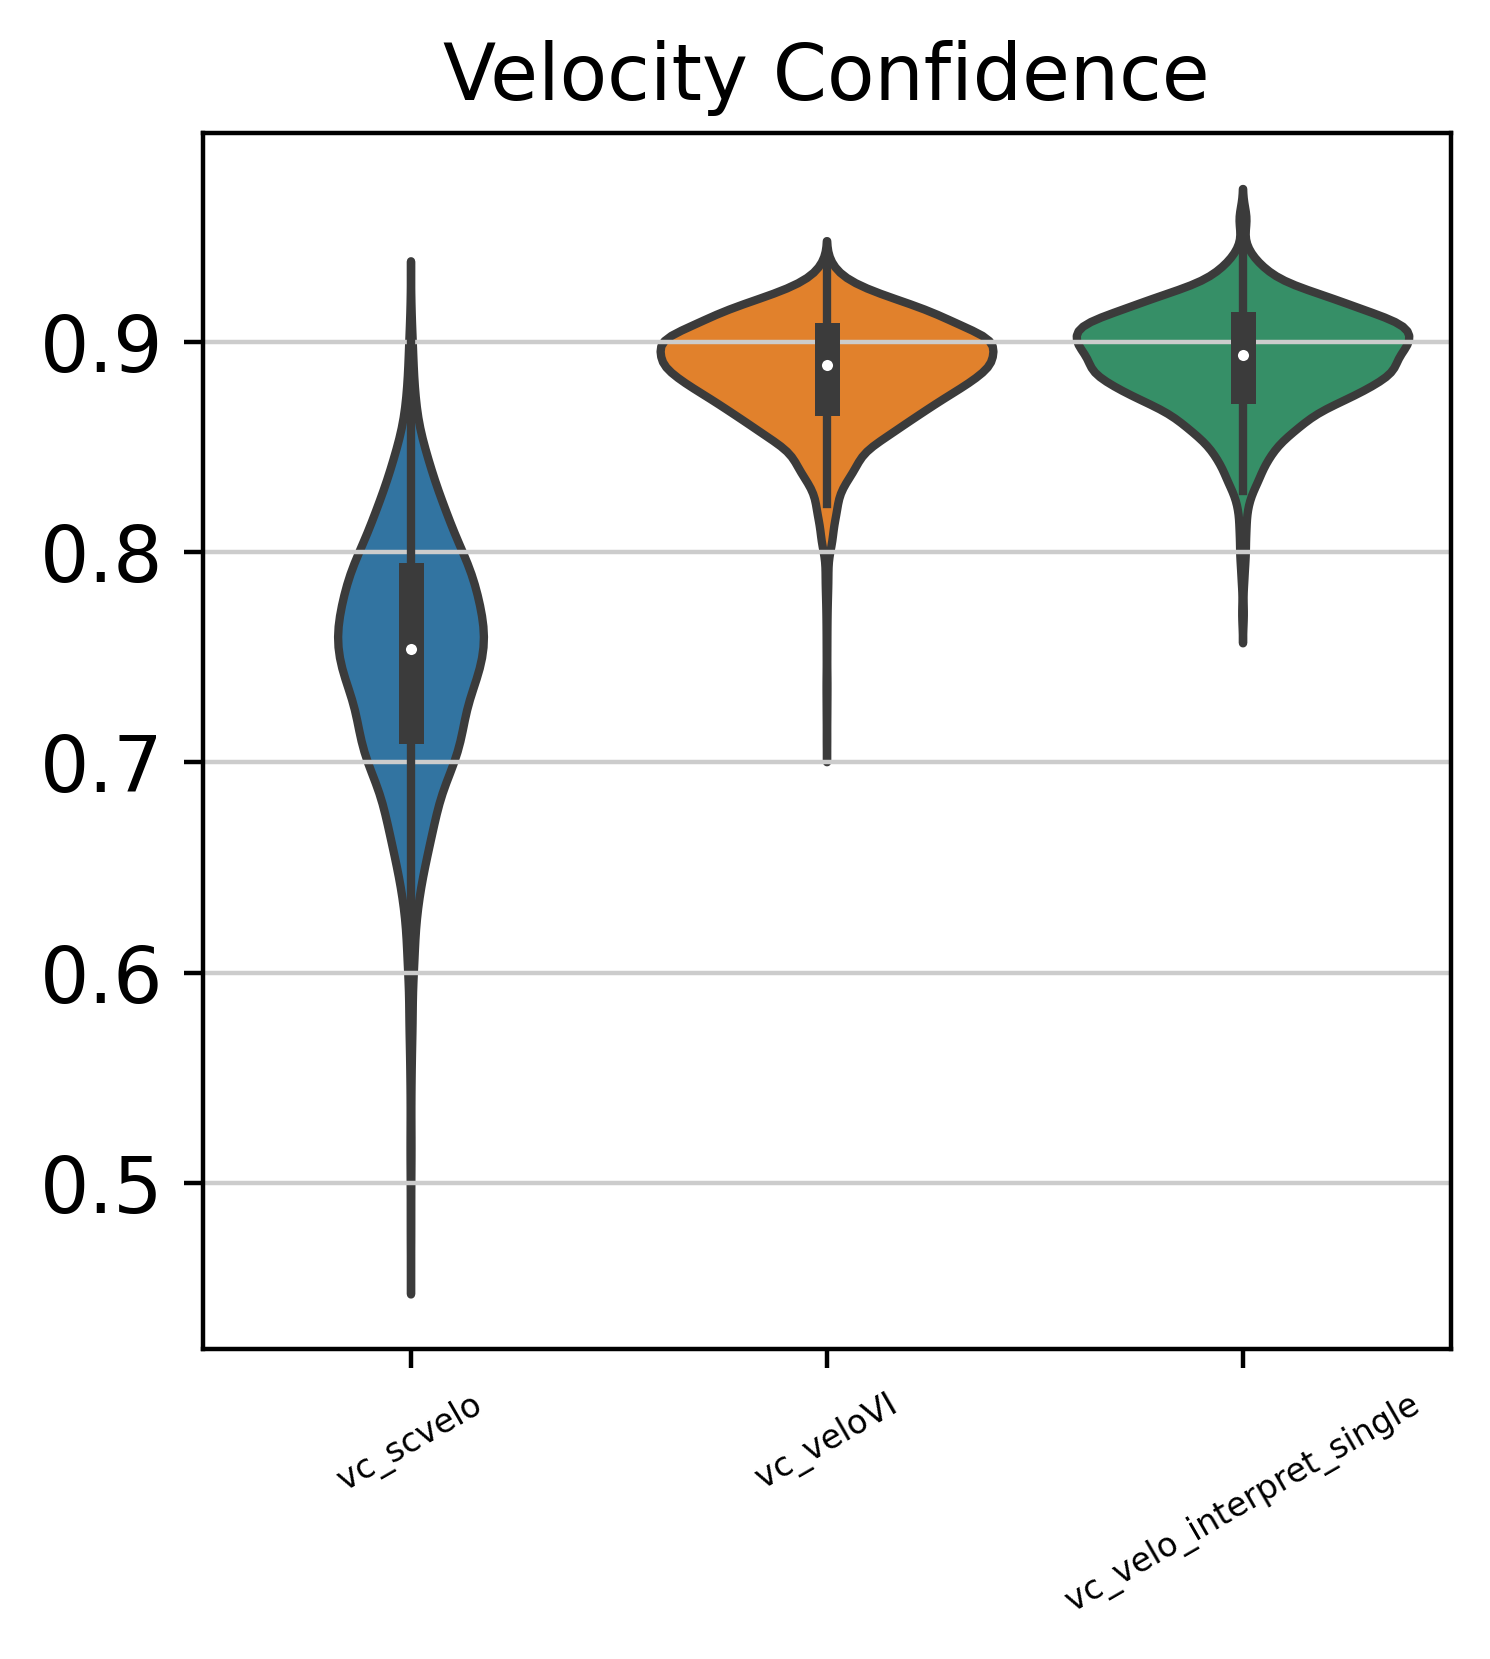

In [49]:
#Get violin plot of velocity confidence
ax=sns.violinplot(data=vc_combined)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, size = 6)
ax.set_title("Velocity Confidence")
fig=ax.get_figure()
#fig.savefig("figures/vel_conf.png") 

Add outputs of velo_interpret to adata

In [43]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    #adata.layers["latent_time_velovi"] = latent_time

    # adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    # adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    # adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    # adata.var["fit_t_"] = (
    #     torch.nn.functional.softplus(vae.module.switch_time_unconstr)
    #     .detach()
    #     .cpu()
    #     .numpy()
    # ) * scaling
    # adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    # adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

Get Velocity graph

In [16]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_velocity_embedding.png


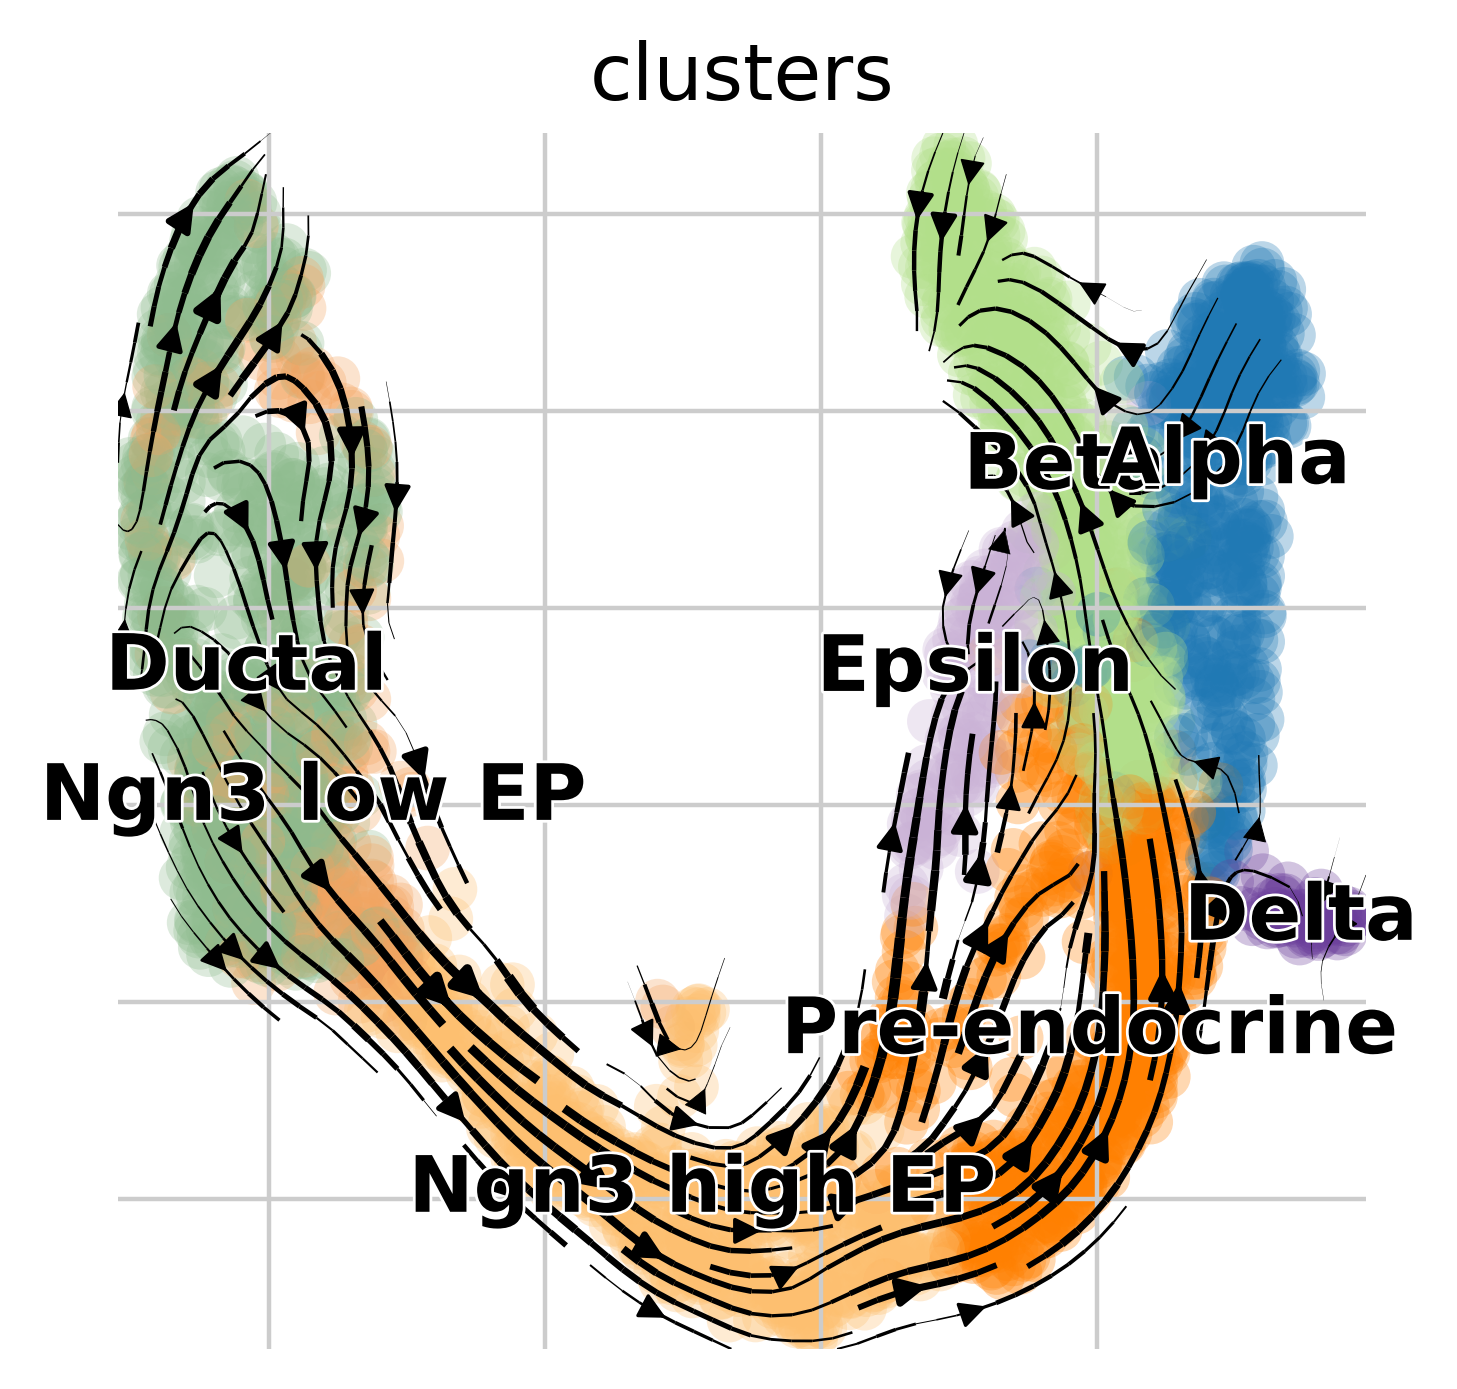

In [18]:
scv.pl.velocity_embedding_stream(adata, basis='umap', save="velocity_embedding")

Intrinsic uncertainty

In [19]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()

INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/an

directional_variance  directional_difference  \
index                                                            
AAACCTGAGAGGGATA              0.003387                0.182226   
AAACCTGAGCCTTGAT              0.005017                0.232567   
AAACCTGAGGCAATTA              0.004597                0.242510   
AAACCTGCATCATCCC              0.004714                0.210303   
AAACCTGGTAAGTGGC              0.004365                0.202090   

                  directional_cosine_sim_variance  \
index                                               
AAACCTGAGAGGGATA                         0.001933   
AAACCTGAGCCTTGAT                         0.002823   
AAACCTGAGGCAATTA                         0.002484   
AAACCTGCATCATCCC                         0.002611   
AAACCTGGTAAGTGGC                         0.002411   

                  directional_cosine_sim_difference  \
index                                                 
AAACCTGAGAGGGATA                           0.135782   
AAACCTGAGCCTTGAT                           0.175187   
AAACCTGAGGCAATTA                           0.179326   
AAACCTGCATCATCCC                           0.155247   
AAACCTGGTAAGTGGC                           0.148144   

                  directional_cosine_sim_mean  
index                                          
AAACCTGAGAGGGATA                     0.666899  
AAACCTGAGCCTTGAT                     0.657598  
AAACCTGAGGCAATTA                     0.677766  
AAACCTGCATCATCCC                     0.676280  
AAACCTGGTAAGTGGC                     0.676280

In [20]:
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)

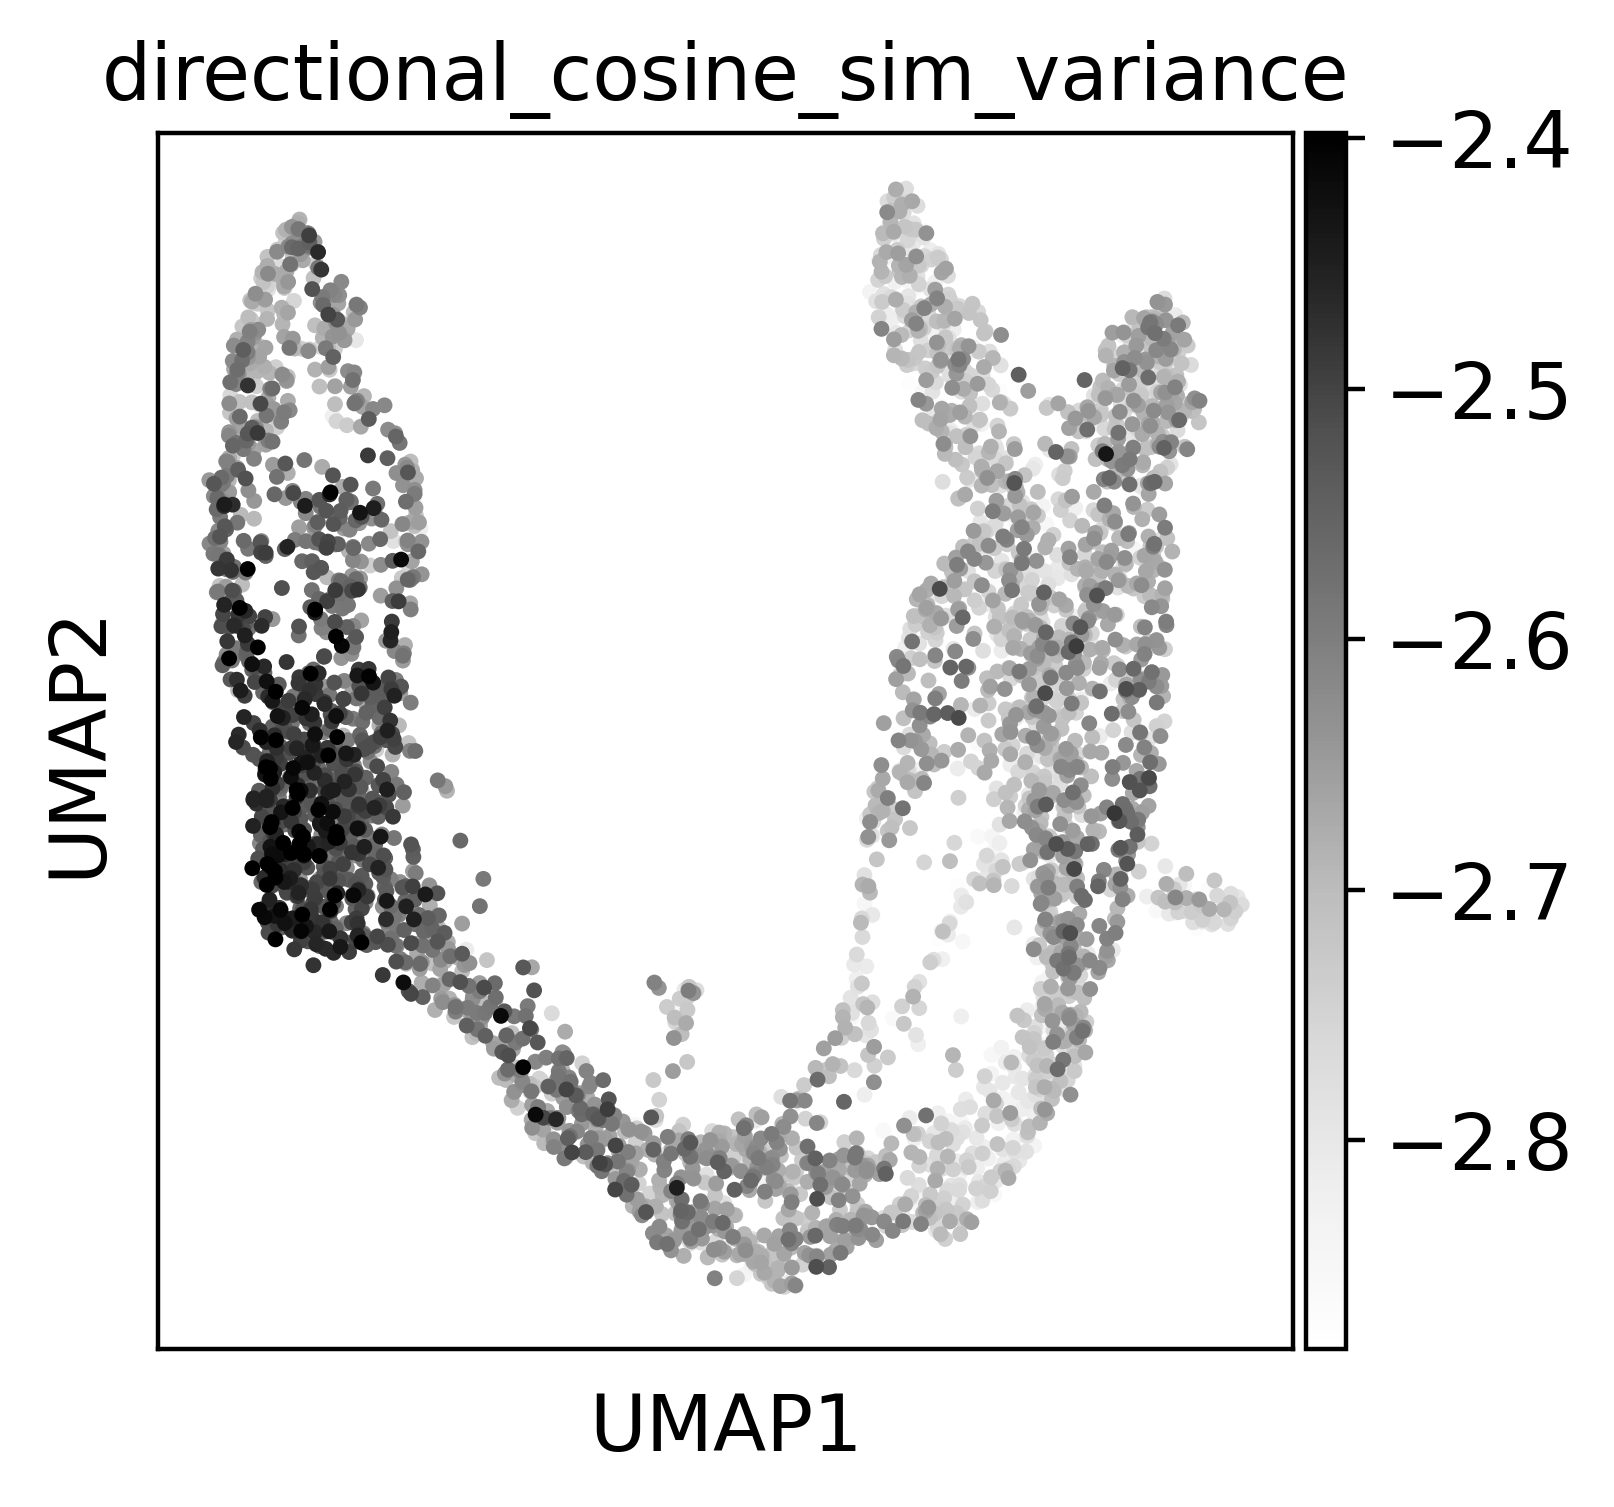

In [22]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
    save="intrinsic_uncertainty.png"
)

Extrinsic uncertainty

In [23]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df

In [24]:
ext_uncertainty_df = compute_extrinisic_uncertainty(adata, vae)

Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [01:02<25:07, 62.83s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [01:21<14:07, 36.85s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [01:38<10:12, 27.83s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [01:55<08:15, 23.58s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [02:14<07:14, 21.74s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [02:32<06:31, 20.59s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [02:51<05:59, 19.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [03:09<05:32, 19.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [03:59<07:40, 28.81s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [04:15<06:14, 24.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [04:32<05:14, 22.44s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [04:48<04:27, 20.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [05:04<03:51, 19.27s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [05:20<03:21, 18.34s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [05:37<02:57, 17.71s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [05:54<02:39, 17.67s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [06:11<02:19, 17.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [06:52<02:52, 24.61s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [07:10<02:14, 22.40s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [07:27<01:44, 20.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [07:44<01:19, 19.76s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [08:02<00:57, 19.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [08:19<00:37, 18.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [08:35<00:17, 17.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [08:52<00:00, 21.31s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/an

In [36]:
for c in ext_uncertainty_df[0].columns:
    adata.obs[c + "_extrinsic"] = np.log10(ext_uncertainty_df[0][c].values)

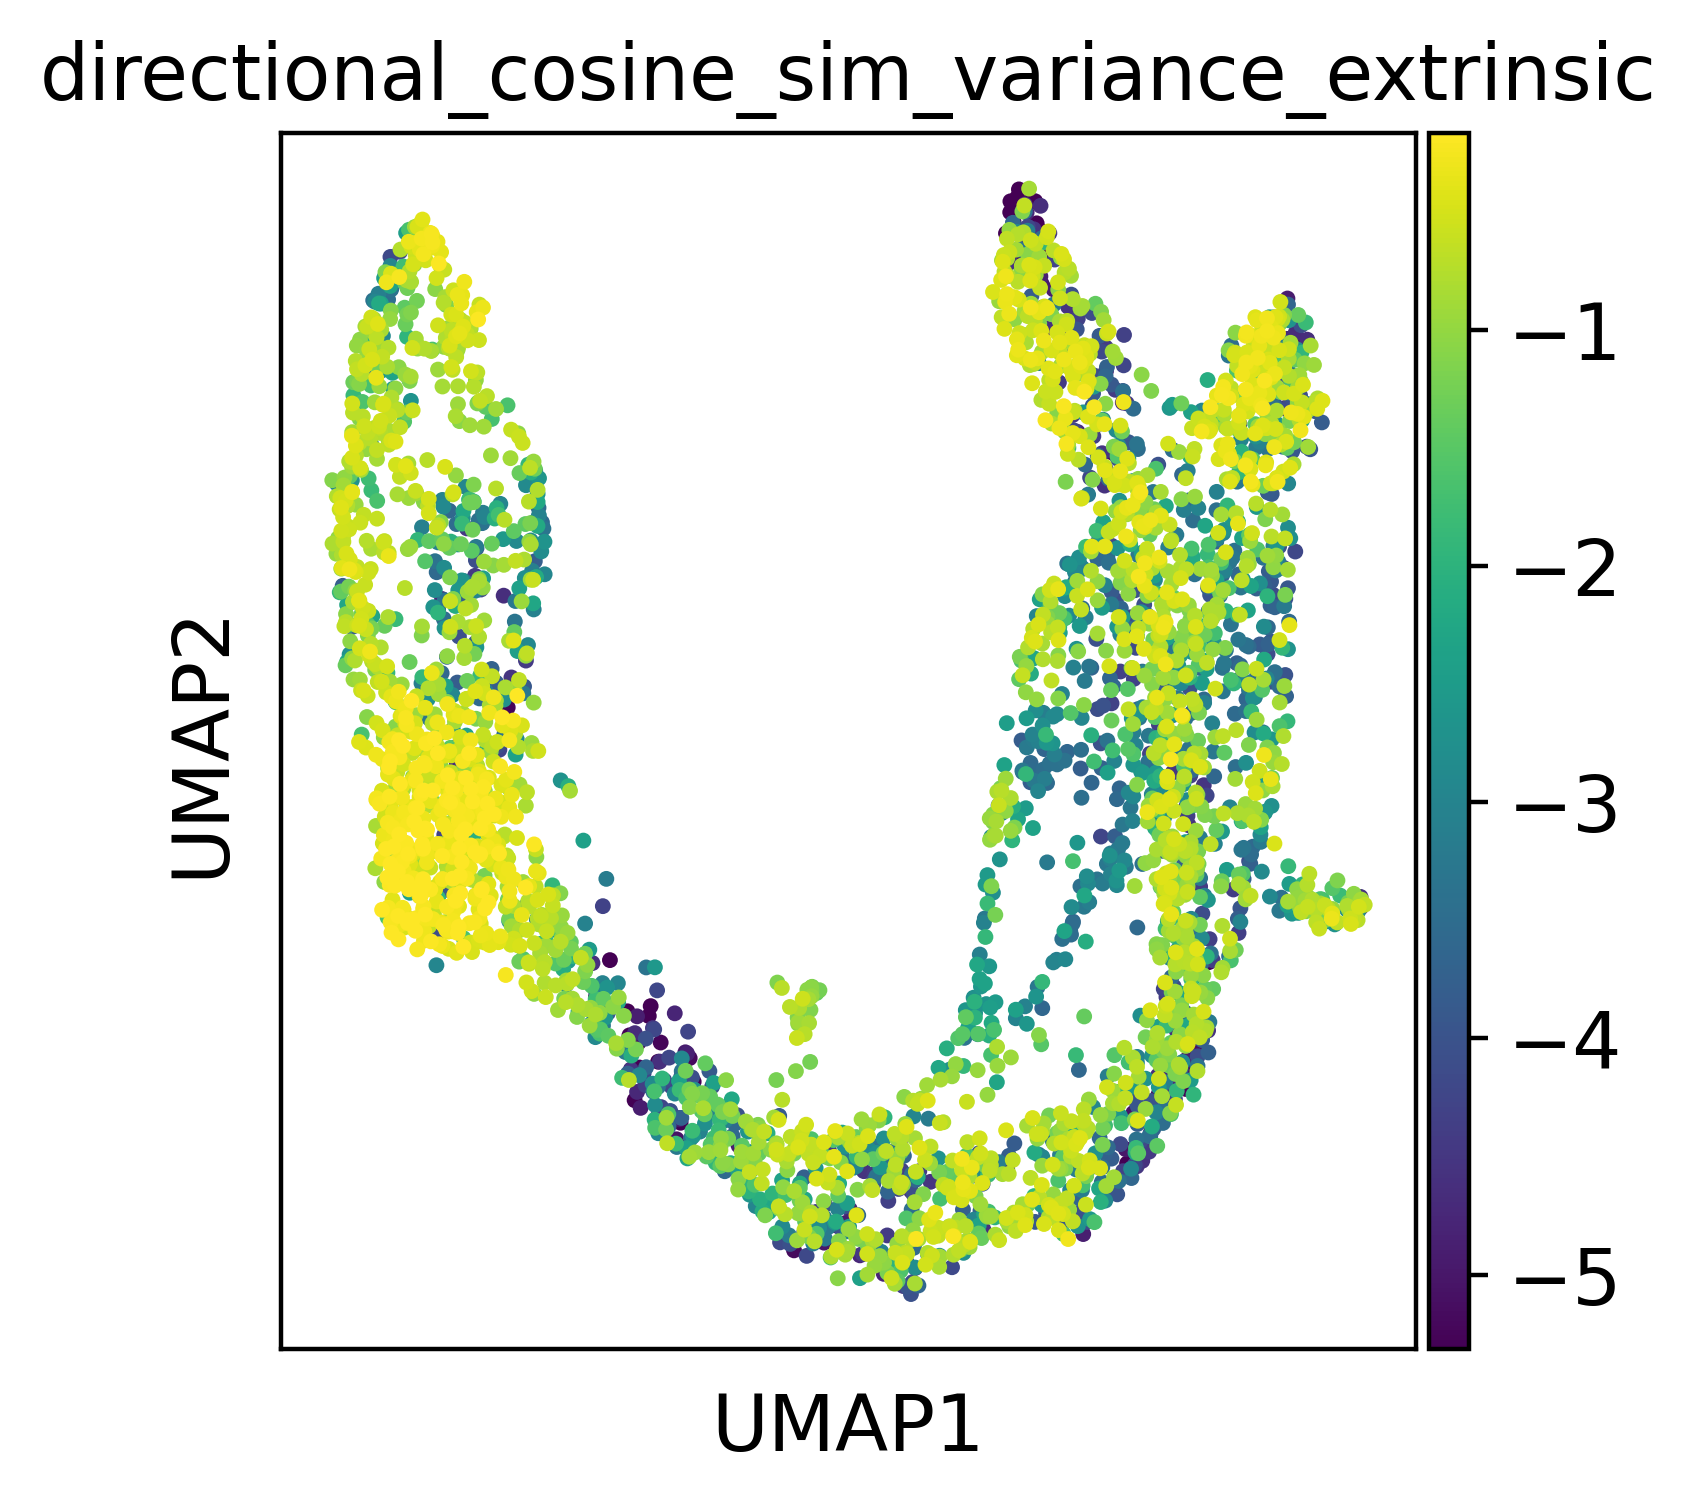

In [37]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance_extrinsic",
    vmin="p1", 
    vmax="p99", 
    save="extrinsic_uncertainty.png"
)

Permutation score

In [38]:
perm_df, _ = vae.get_permutation_scores(labels_key="clusters")
adata.var["permutation_score"] = perm_df.max(1).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


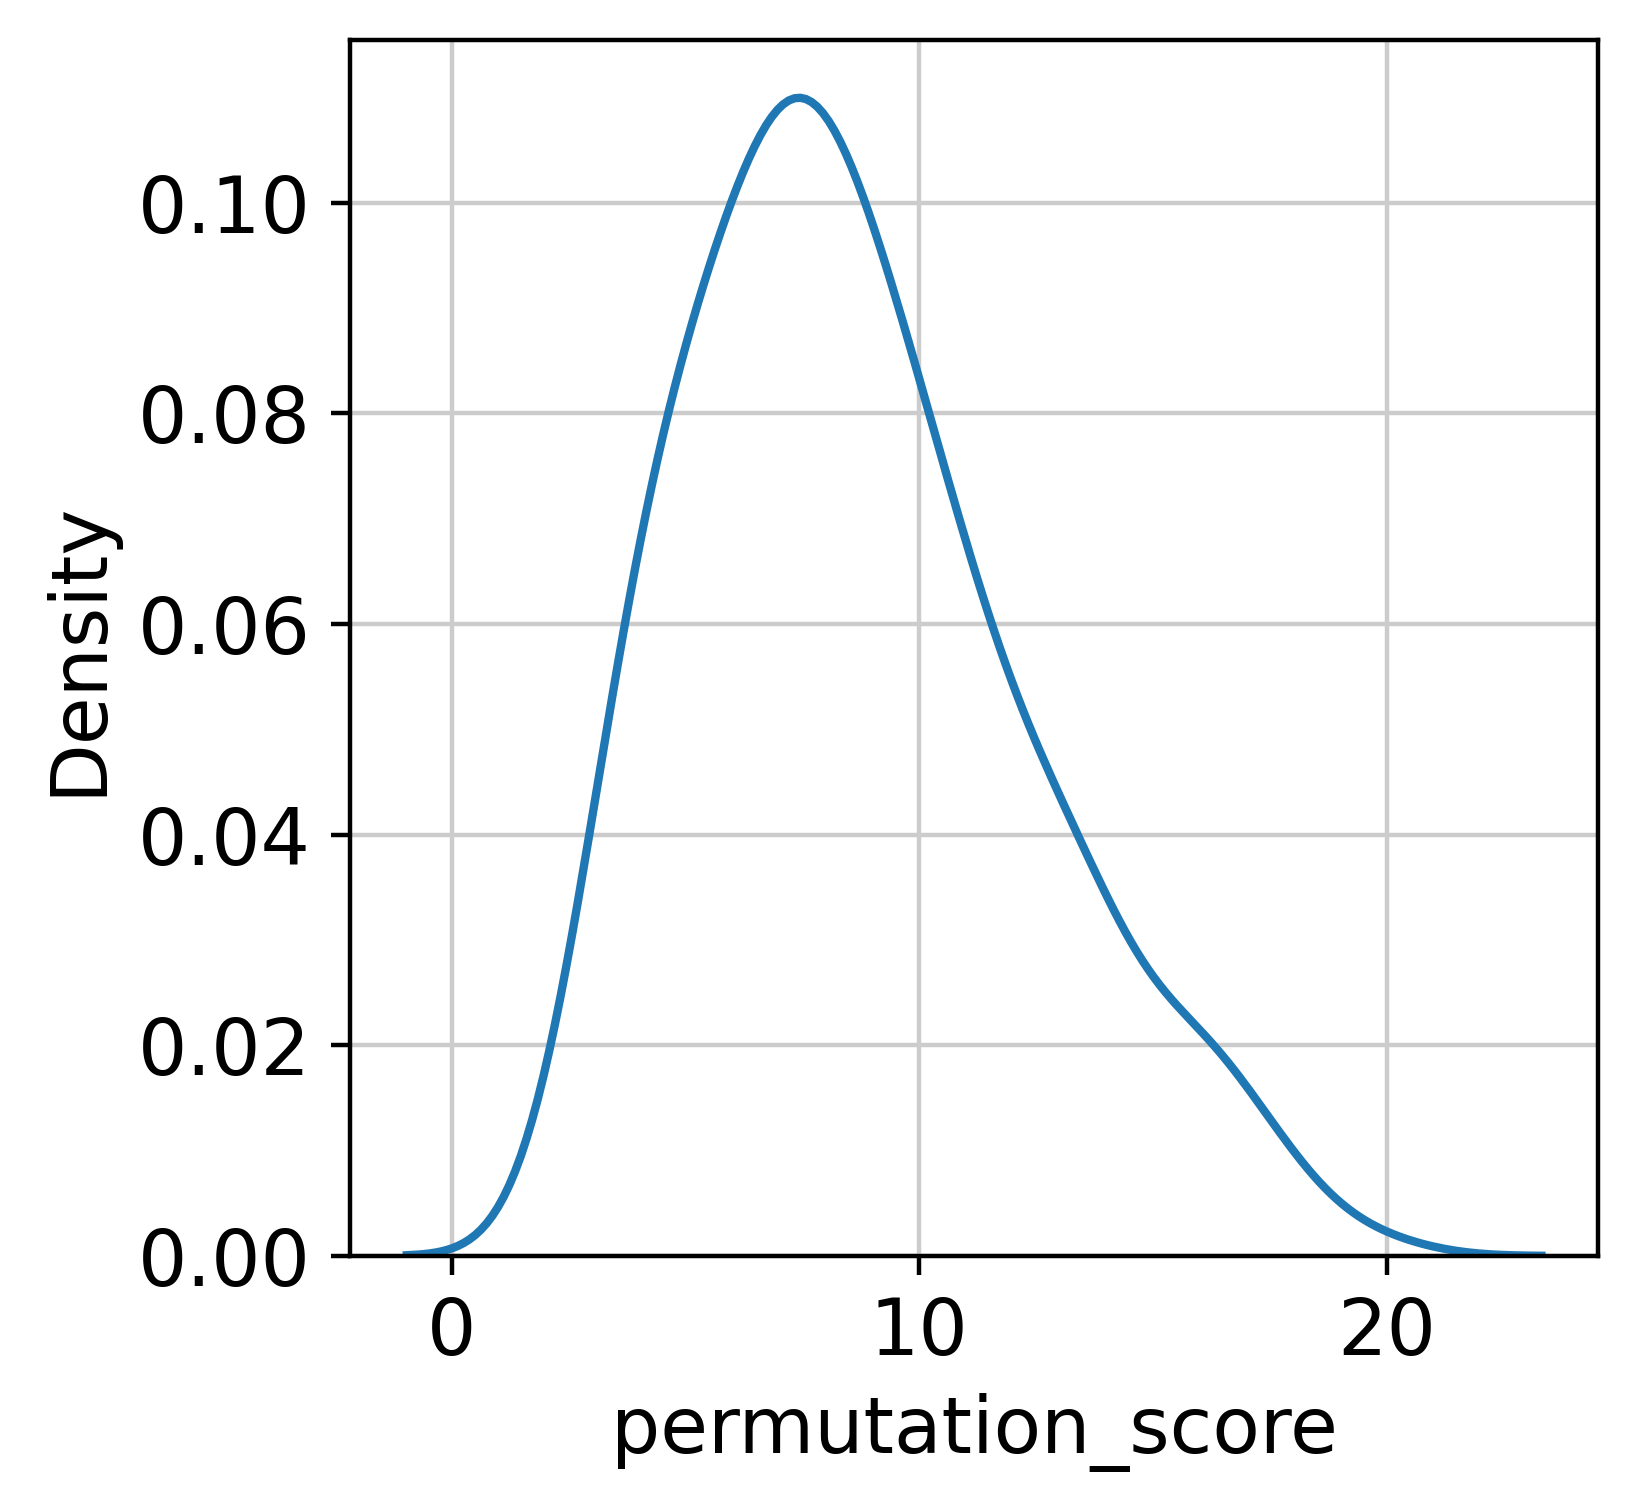

In [42]:
perm_score=sns.kdeplot(data=adata.var, x="permutation_score")
perm_score_fig=perm_score.get_figure()
perm_score_fig.savefig("figures/permutation_score.png") 

In [ ]:
#Sunday
#run without soft mask
#check if GPs are decreasing (look at GPs not included in original pancreas app to expimap)
#get latent directions
#plot GPs
#Compare with orig velovi

#Monday
#Apply other decoder
